# Data Cleaning and Summary Statistics

In [1]:
import csv
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,6)

In [19]:
dat = csv.reader(open('data.txt','r'), delimiter = ' ',quotechar='"')
df = pd.DataFrame(next(dat))
df = df.transpose()

for i in dat:
    df_ = pd.DataFrame([i])
    df = pd.concat([df, df_])

I read the data in using a line-by-line method because pd.read_csv failed due to encoding issues. This is because there are some non-English publication titles.

In [35]:
df.iloc[[1462, 1730, 4214, 6582]]

,0,1,2,3
0,Davis,Kueltz,Experimentelle Untersuchungen zur Funktion der...,1992
0,Davis,Medrano,Manipulación de la curva de lactación y de la ...,2006
0,TAMU,Tedeschi,Níveis de inclusão e tempo de exposição da can...,2010
0,Florida,Binelli,Interação entre nutrição protéica e aspectos r...,2008


I found these by looking through the dataset by hand. These seem like legitimate publication titles, but they won't cluster with the English papers. It's not possible to remove them all by hand, so I will leave them. Because most a vast majority of the publication titles are in English, these few non-English ones will likely have little effect.

In [3]:
df.columns = ['school', 'name', 'title', 'year']
df['year'] = pd.to_numeric(df['year'])

In [4]:
# Drop out all observations that are for the wrong person
df = df[~((df.name == "Cheng") & (df.school == "Davis"))]
df = df[~((df.name == "Davis") & (df.school == "Ohio"))]

The issue with these two professors is that they had very common names with no middle initial available, so there were professors at the same universities with their same name.

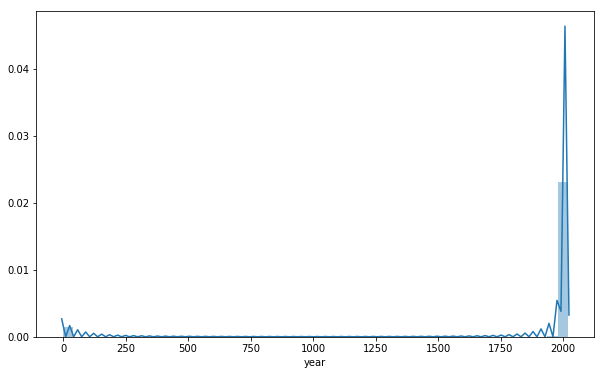

In [20]:
sns.distplot(df.year)

The observations with year 0 are known to be issues with reading in data, so those should be removed. There are also some papers in the 1600's. These cannot be legitimate because I chose only active (not Emiriti) professors, and they weren't even born yet in 1600. The oldest professors in the UC Davis animal science department got their PhD's in the 1970's so I decided that a reasonable cutoff would be 1960. Any years before that should be considered a mistake by scholarly in reading the data from Google Scholar.

In [5]:
# Get rid of rows that are mistakes (including 0)
df = df[df.year > 1960]

In [6]:
# Export the cleaned data
df.to_csv("cleaned.txt", sep=' ', index=False, header=False)

## Now that the data is clean, we can start exploring

In [47]:
df.groupby(['school'])['title'].count()

school
Cornell     291
Davis      1493
Florida    2508
Ohio        420
TAMU       2766
Name: title, dtype: int64

In [45]:
df.name.nunique()

56

In [46]:
df.groupby('school').agg({'name': 'nunique'})

,name
school,
Cornell,2
Davis,12
Florida,22
Ohio,7
TAMU,14


In [8]:
# Count up the total number of publications for each professor
c = pd.DataFrame(df.groupby(['school','name'])['title'].size())
c = c.reset_index()
c.columns = ["school1", "name1", "count"]

# Get the year of the first paper for each professor
s = pd.DataFrame(df.groupby(['school','name'])['year'].min())
s = s.reset_index()
s.columns = ["school2", "name2", "year"]

total = pd.concat([c,s], axis = 1)
total = total.drop(total.columns[[3,4]], axis=1)
total.columns = ["school","name","count","year"]
total

,school,name,count,year
0,Cornell,Amburgh,188,1981
1,Cornell,Ketterings,103,1997
2,Davis,Berger,157,1979
3,Davis,Eadie,121,1979
4,Davis,Horback,14,2010
5,Davis,Kebreab,431,1999
6,Davis,Kueltz,110,1991
7,Davis,Liu,41,2006
8,Davis,Makagon,31,2005
9,Davis,Medrano,303,1973


Because scholarly returns every publication for a given profile, the number of publications reaturned for each professor is meaningful. However, it is natural that older professors would have more publications, since they have had more time. I don't have data for age or the year they got their PhD, so I will use the year of their first paper as a measure of how old they are. This seems like a reasonable measure of age because most people publish their first paper during grad school, which is a narrow range of ages.

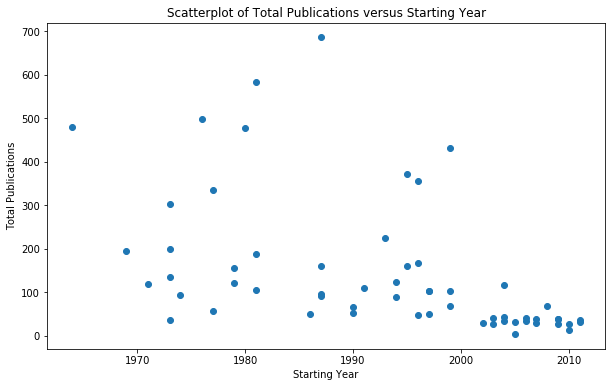

In [43]:
plt.scatter(x = "year", y = "count", data=total)
plt.title("Scatterplot of Total Publications versus Starting Year")
plt.ylabel("Total Publications")
plt.xlabel("Starting Year")

plt.show()

I expected that older professors would have more papers. This trend seems generally true, but older professors seem to have a lot of variation, while younger professors have less variation and tend to be lower. There is one professor in the middle that has almost 700 papers, which is a lot. 

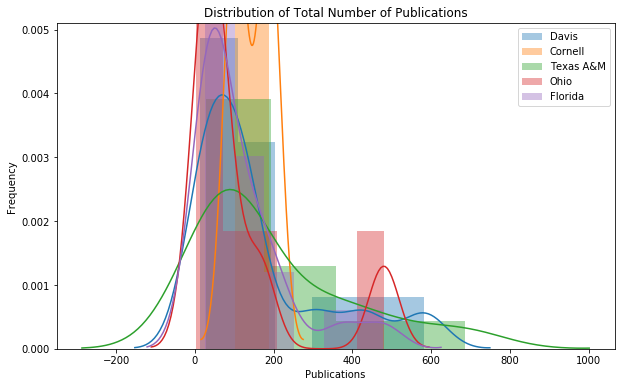

In [25]:
davis = total[total.school=="Davis"]["count"]
cornell = total[total.school=="Cornell"]["count"]
tamu = total[total.school=="TAMU"]["count"]
ohio = total[total.school=="Ohio"]["count"]
florida = total[total.school=="Florida"]["count"]

d = sns.distplot(davis)
sns.distplot(cornell)
sns.distplot(tamu)
sns.distplot(ohio)
sns.distplot(florida)
d.set(title = "Distribution of Total Number of Publications", 
      xlabel = "Publications", ylabel = "Frequency")
plt.legend(["Davis","Cornell", "Texas A&M", "Ohio", "Florida"]) 

plt.show()

# Word Clouds
Word clouds would be helpful to see what topics are commonly studied. I am interested to know if the word clouds look radically different at the different universities.

Also, I am interested to know what are some current "hot topics" in animal science. For this, I can make a word cloud of publications that are from the past two years.


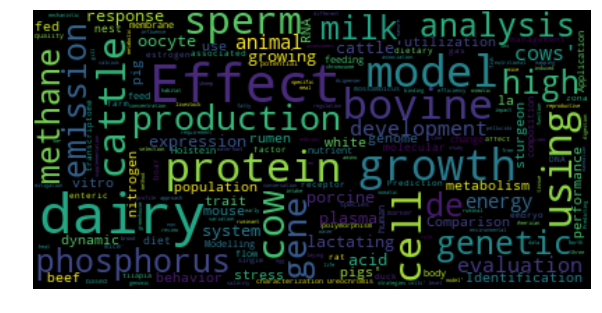

In [10]:
davis = df[df.school == "Davis"]
wordcloud = WordCloud(max_font_size=40, 
                      collocations=False).generate(str(davis["title"].tolist()))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Insights about the Davis word cloud:
- "Dairy" is very large. This does not surprise me, because California has a very large dairy industry, especially in the Central Valley and Souther California. "Cow" is also fairly large. The term cow refers to an adult female bovine, which is the gender primarily associated with dairies (because males and young animals don't make milk).
- "Sperm" is very large, indicating that a lot of research is going on about artificial insemination, which is an important aspect of the dairy industry. 
- "Protein" is also very large but I think this can have multiple contexts--some professors study protein expression levels in cells (for example during different environmental conditions) and some professors study protein levels fed in the diet and how those can affect an animal's health and growth.

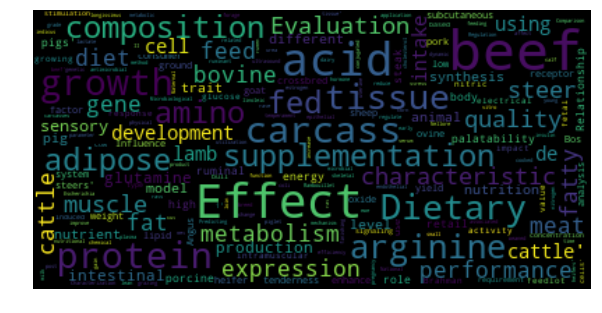

In [7]:
tamu = df[df.school == "TAMU"]
wordcloud = WordCloud(max_font_size=40, 
                      collocations=False).generate(str(tamu["title"].tolist()))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Insights about the Texas A&M word cloud:  
- The major theme in this word cloud is "beef". "Steer" is also fairly large. A steer is a castrated male, and this is the gender primarily associated with the beef industry because males are more muscular than females (resulting in more meat when slaughtered) and castrated males are more common than intact males due to reduced aggression. 
- "Carcass", which refers to the slaughtered animal, is fairly large, indicating that meat quality is an important research area at Texas A&M. "Adipose" and "quality" are also related to meat quality.
- "Dietary", "arginine", "fatty", "amino", and "supplementation" are large, and this is likely due to studies about different diets being fed to animals.

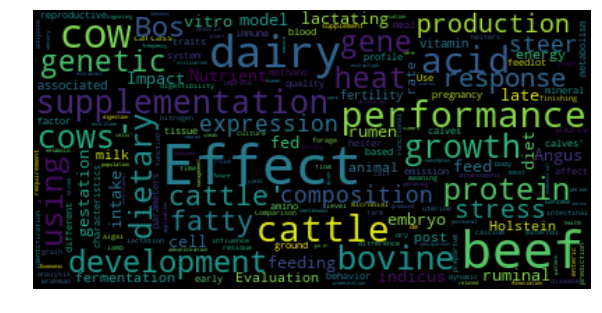

In [12]:
recent = df[df.year > 2015]
wordcloud = WordCloud(max_font_size=40, 
                      collocations=False).generate(str(recent["title"].tolist()))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()